# Multiwavelength GAN architecture
Added by Shooby Oct 24th<br>
Last edited: Oct 30th<br>

In [1]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel

from astropy.convolution import convolve_fft as convolve
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

import warnings
warnings.filterwarnings('ignore')

from torch.utils.tensorboard import SummaryWriter


In [2]:
device = torch.device("cpu") # If GPU then use "cuda:0"
ngpu = 3 #number of GPUs to use 
ngf = 64
ndf = 64
workers = 8 #number of data loading workers
batchSize = 64 #input batch size
imageSize = 64 #the height / width of the input image to network

nz = 16 #size of the latent z vector
niter = 5 #number of epochs to train for
lr = 0.001 #learning rate, default=0.0002
beta1 = 0.7 #beta1 for adam. default=0.5
outf='../outputs' #folder to output images and model checkpoints
ngc = 7

manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  9902


In [27]:
from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom

psf = pyfits.getdata('../psfs/psf_i.fits')
psf = downscale_local_mean(psf,(3,3))
psf = psf[8:-8,8:-8]#[22:-22,22:-22]


psf_hsc = pyfits.getdata('../psfs/PSF_subaru_i.fits')
psf_hsc = psf_hsc[2:42,2:42]
print(psf_hsc.shape)

kern = create_matching_kernel(psf,psf_hsc)
print(kern.shape)

psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()
print(kernel.shape)


(43, 43)
(40, 40)
(40, 40)
torch.Size([1, 1, 40, 40])


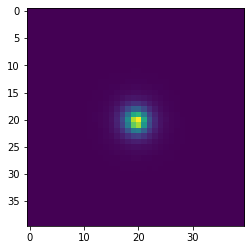

In [4]:
plt.imshow(kern)


In [5]:
from galaxy_hdf5loader import galaxydata

dataset = galaxydata('../Sample.hdf5')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,shuffle=True, num_workers=int(0))


In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=True, num_workers=int(0))

for i in dataloader:
    a = (i[0].data.numpy())
    stop

NameError: name 'stop' is not defined

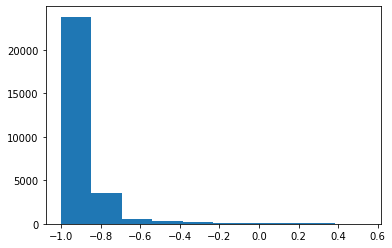

In [7]:
b = plt.hist(a.flatten())

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(ngc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if netD != '':
#    netD.load_state_dict(torch.load(netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(7, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(ngc, ngf * 4, 7, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.ConvTranspose2d( ngf*4, ngf * 8, 6, 3, 2,dilation=2, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
  
            nn.ConvTranspose2d(ngf*4, ngc, 4, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1

netS = Shoobygen(ngpu).to(device)
netS.apply(weights_init)
print(netS)

Shoobygen(
  (main): Sequential(
    (0): Conv2d(7, 256, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(256, 512, kernel_size=(6, 6), stride=(3, 3), padding=(2, 2), dilation=(2, 2), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 7, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [26]:
import torchvision

criterion = nn.BCELoss()
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerS = optim.Adam(netS.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        
        real_cpu = real_cpu.float()
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        # train with resampled, lower res, noise added images
        kernel = kernel.to(device)
        #im = real_cpu+0.25*torch.rand_like(real_cpu)
        #downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
        downsampled_resh = real_cpu.view(-1,1,64,64)
        img2 = F.conv2d(downsampled_resh, kernel,padding=8,stride=2)
        img = img2.view(-1,7,21,21)
        img = img+0.25*torch.rand_like(img)
        img = img[:,:,:,:]

        fake = netS(img)
        label.fill_(fake_label)
        fd = fake.detach()
        output = netD(fd.float())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netS.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerS.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            print(i)
            real_cp = real_cpu[:,3,:,:].reshape(batch_size,1,64,64)        
            vutils.save_image(real_cp,'%s/real_samples.png' % outf, normalize=True)
            fake = netS(img)
            fak = fake[:,3,:,:].reshape(batch_size,1,66,66)
            vutils.save_image(fak.detach(),'%s/fake_samples_epoch_%03d.png' % (outf, epoch),normalize=True)
            grid = torchvision.utils.make_grid(fak.detach())
            
    # do checkpointing
    torch.save(netS.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))
    stop


[0/5][0/3156] Loss_D: 27.6310 Loss_G: 0.0000 D(x): 1.0000 D(G(z)): 1.0000 / 1.0000
0
[0/5][1/3156] Loss_D: 27.6310 Loss_G: 0.0000 D(x): 1.0000 D(G(z)): 1.0000 / 1.0000
[0/5][2/3156] Loss_D: 14.1506 Loss_G: 45.9639 D(x): 1.0000 D(G(z)): 1.0000 / 0.0000
[0/5][3/3156] Loss_D: 0.0000 Loss_G: 44.8239 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[0/5][4/3156] Loss_D: 0.0000 Loss_G: 50.4888 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[0/5][5/3156] Loss_D: 0.0000 Loss_G: 55.5693 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[0/5][6/3156] Loss_D: 0.0005 Loss_G: 57.6712 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000


KeyboardInterrupt: 